In [7]:
import pandas as pd
import random as rnd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [8]:
#ML tools:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

### Loading Data.
For more information about this data see the "Memoir" document and the "DB Creator" notebook.

In [21]:
pre_train = pd.read_csv("./Data/preprocessed_TRAIN_csv").drop('Unnamed: 0',axis=1)
train = pd.read_csv("./Data/TRAIN_csv").drop('Unnamed: 0',axis=1)
scaled_train = pd.read_csv("./Data/TRAIN_scaled_CSV").drop('Unnamed: 0',axis=1)
pre_test = pd.read_csv("./Data/preprocessed_const_csv").drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)
test = pd.read_csv("./Data/TEST_const_csv").drop(['Unnamed: 0','Unnamed: 0.1'],axis=1)

In [22]:
print(pre_train.shape)
print(train.shape)
print(scaled_train.shape)
print(pre_test.shape)
print(test.shape)

(3555, 5)
(3530, 8)
(3530, 8)
(223, 5)
(223, 8)


### Let's plot TEST looking for correlations and diferentiating typologies by color.

(223, 5)


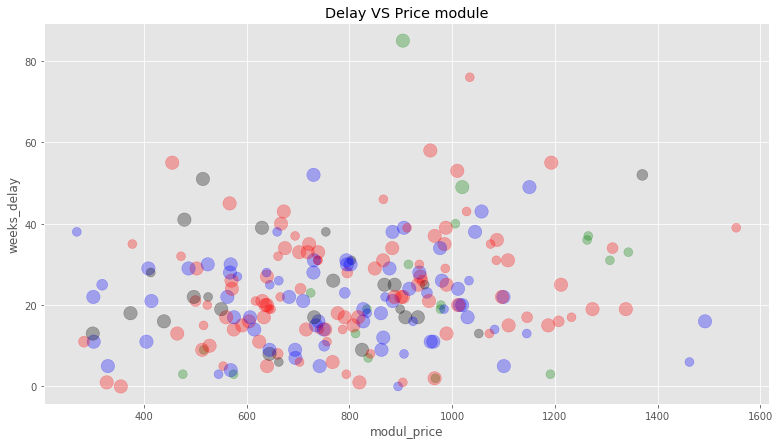

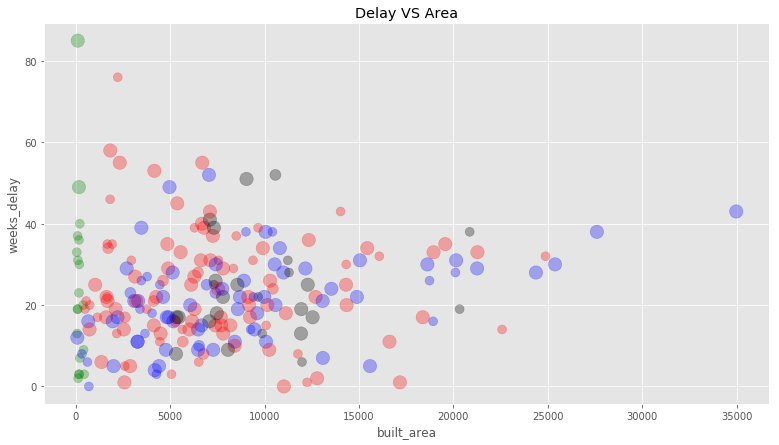

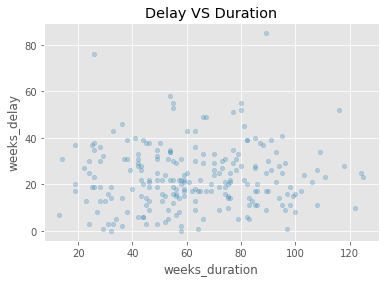

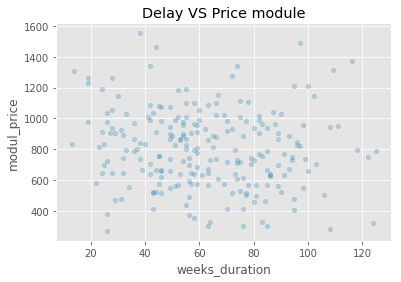

In [27]:
print(pre_test.shape)

#Let's plot diferentiating typologies by color.
color= ['black' if l == "COMMERCIAL" else 'blue' if l == "OTHERS" else 'green' if l== "DETACHED" 
        else 'red' for l in pre_test["typology"]]

#Creating a list to assign size of the plots to a variable. 
#This case we will use the construction duration.
size= [20 if n < 13 else 80 if n <50 else 180 if n <100 else 120
         for n in pre_test["weeks_duration"]]

#Scatterplotting to see the distribution:
pre_test.plot.scatter(x='modul_price', y="weeks_delay", title="Delay VS Price module",
                       color=color, alpha=0.3,figsize=(13, 7),s=size)
pre_test.plot.scatter(x="built_area", y="weeks_delay", title="Delay VS Area",
                       color=color, alpha=0.3,figsize=(13, 7),s=size)
pre_test.plot.scatter(x="weeks_duration", y="weeks_delay", title="Delay VS Duration", alpha=0.3)
pre_test.plot.scatter(x="weeks_duration", y='modul_price', title="Delay VS Price module", alpha=0.3)

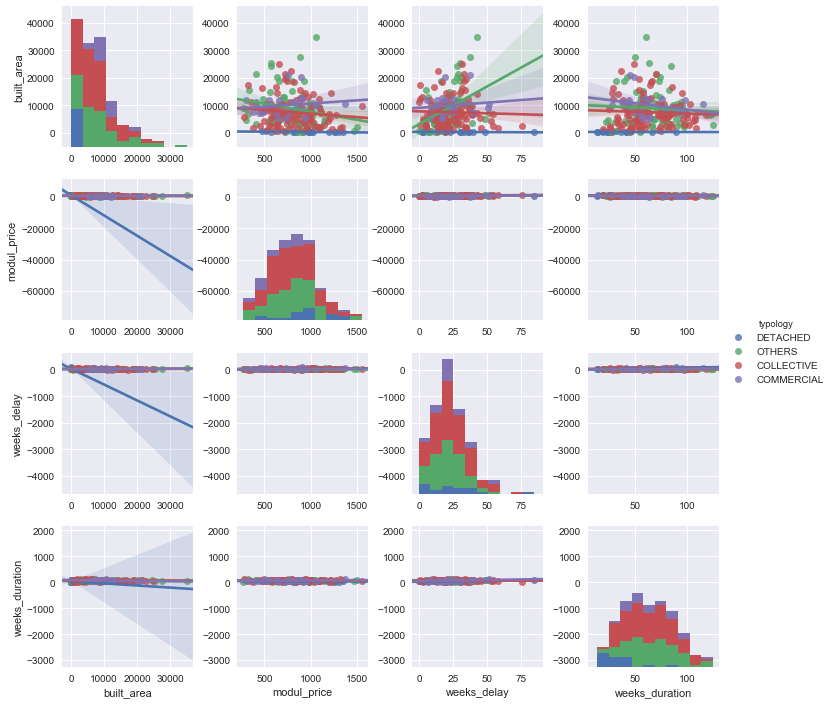

In [28]:
#Correlations.
sns.set()
sns.pairplot(pre_test, hue="typology",kind="reg")

### Let's plot TRAIN diferentiating typologies by color.

(3555, 5)


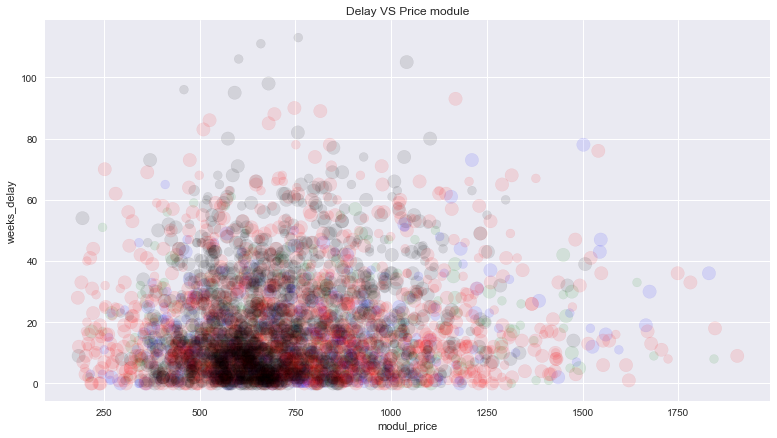

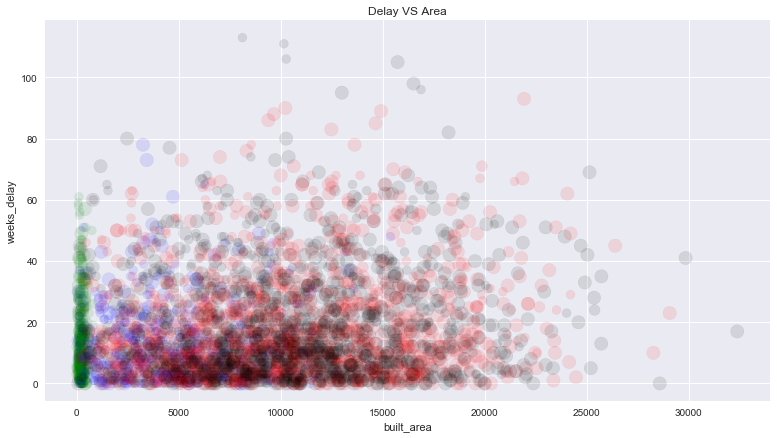

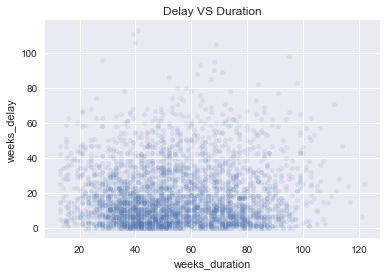

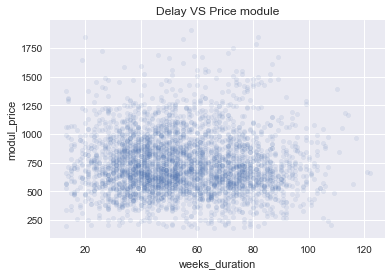

In [29]:
print(pre_train.shape)

#Let's plot diferentiating typologies by color.
color= ['black' if l == "COMMERCIAL" else 'blue' if l == "OTHERS" else 'green' if l== "DETACHED" 
        else 'red' for l in pre_train["typology"]]

#Creating a list to assign size of the plots to a variable. 
#This case we will use the construction duration.
size= [20 if n < 13 else 80 if n <50 else 180 if n <100 else 120
         for n in pre_train["weeks_duration"]]

#Scatterplotting to see the distribution:
pre_train.plot.scatter(x='modul_price', y="weeks_delay", title="Delay VS Price module",
                       color=color, alpha=0.1,figsize=(13, 7),s=size)
pre_train.plot.scatter(x="built_area", y="weeks_delay", title="Delay VS Area",
                       color=color, alpha=0.1,figsize=(13, 7),s=size)
pre_train.plot.scatter(x="weeks_duration", y="weeks_delay", title="Delay VS Duration", alpha=0.1)
pre_train.plot.scatter(x="weeks_duration", y='modul_price', title="Delay VS Price module", alpha=0.1)

### We have to scale Test Data to use it within the models.
So we will use two premade DFs for this task. One made of Means and other of Std values of Train Data. 

In [30]:
means = pd.read_csv("./Data/TRAIN_mean_CSV").drop('Unnamed: 0',axis=1)
stds = pd.read_csv("./Data/TRAIN_std_CSV").drop('Unnamed: 0',axis=1)
print(stds.sample(3))

          var          val
7     DELAYED     0.493508
6      OTHERS     0.340390
0  built_area  5881.154888


In [31]:
def uniqscaler(float_,mean_,std_):
    uniqscaled = (float_ - mean_)/std_
    return uniqscaled

def scaler(df_): 
    ba_scaled = uniqscaler(df_['built_area'],
                           means.query("var == 'built_area'")['val'],
                           stds.query("var == 'built_area'")['val'])
    mp_scaled = uniqscaler(df_['modul_price'],
                           means.query("var == 'modul_price'")['val'],
                           stds.query("var == 'modul_price'")['val'])  
    wd_scaled = uniqscaler(df_['weeks_duration'],
                           means.query("var == 'weeks_duration'")['val'],
                           stds.query("var == 'weeks_duration'")['val'])
    scaled ={'built_area':ba_scaled.values.item(0),
             'modul_price':mp_scaled.values.item(0),
             'weeks_duration':wd_scaled.values.item(0)}
    return scaled

scaled_parttest = test.apply(scaler,axis=1).tolist()
scaled_parttest = pd.DataFrame(scaled_parttest)
scaled_test = pd.concat([scaled_parttest,
                        test[['DETACHED', 'COLLECTIVE','COMMERCIAL','OTHERS','DELAYED']]], 
                        axis=1)

print(scaled_test.sample(3))

     built_area  modul_price  weeks_duration  DETACHED  COLLECTIVE  \
87    -0.690747    -0.344958       -1.470552         0           0   
163   -0.346214     0.535443       -0.049797         0           0   
191    3.244708     0.622475       -0.196771         0           0   

     COMMERCIAL  OTHERS  DELAYED  
87            0       1        1  
163           0       1        0  
191           0       1        1  


In [32]:
X_train = scaled_train.loc[:,'built_area':'OTHERS']
y_train = scaled_train['DELAYED']
X_test = scaled_test.loc[:,'built_area':'OTHERS']
y_test = scaled_test['DELAYED']

# Test and combination of ML models:
Due to the impossibility for the client (construction managers) most of the times, to manipulate every parameter in the construction project, it is useless to recomend global optimal parameters. So the nature of this problem force us to focus in local optima rather than on globals. So, we have to refine the models to avoid overfitting, but taking care of not "softening" the models too much. With the confussion matrix in mind, so we are open to have a model with many False Positives (of potentially delayed construction projects but finally not delayed). This way we won't take the risk of regularizing the models too much nd loosing valuable information.

In [33]:
#K-NEIGHBORS:
knn =KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred_kn = knn.predict(X_test)
print("KNEIGHBORS REGRESSION MODEL: ")
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_kn)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_kn, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")

KNEIGHBORS REGRESSION MODEL: 
Normalized accuracy: 0.533632286996
Net accuracy: 119 over 223 samples.


In [34]:
#LOGISTIC:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lg = logreg.predict(X_test)
print("LOGISTIC REGRESSION MODEL: ")
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_lg)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_lg, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")

LOGISTIC REGRESSION MODEL: 
Normalized accuracy: 0.632286995516
Net accuracy: 141 over 223 samples.


In [35]:
#RANDOM FOREST CLASSIF:
ranfor = RandomForestClassifier(max_depth=3,max_features=3, random_state=0)
ranfor.fit(X_train, y_train)
y_pred_rf = ranfor.predict(X_test)
print("RANDOM FOREST MODEL: ")
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_rf)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_rf, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")

RANDOM FOREST MODEL: 
Normalized accuracy: 0.686098654709
Net accuracy: 153 over 223 samples.


# Evaluating ML tools performance and combination:
As we will see, the performance and predictions of random forest and logistic regression tools are similar, probably because of the scarcity of samples. We will combine these tools only to score the confidence of the prediction, as they will predict the same labels most of the times.

In [36]:
# Coincidence between models:
print("LOGIST VS RANDFOR: " + str(accuracy_score(y_pred_lg,y_pred_rf)))
print("LOGIST VS K-NEIGH: " + str(accuracy_score(y_pred_lg,y_pred_kn)))
print("RANDFOR VS K-NEIGH: " + str(accuracy_score(y_pred_rf,y_pred_kn)))

LOGIST VS RANDFOR: 0.739910313901
LOGIST VS K-NEIGH: 0.686098654709
RANDFOR VS K-NEIGH: 0.632286995516


# Observating disagreement between algorithms.

In [37]:
ykn = pd.DataFrame(y_pred_kn).rename(columns={0:"kn"}).reset_index()
ylg= pd.DataFrame(y_pred_lg).rename(columns={0:"lg"})
yrf= pd.DataFrame(y_pred_rf).rename(columns={0:"rf"})
y_concat = pd.concat([ykn,ylg,yrf],axis=1)

diff1 = y_concat['kn'] != y_concat['lg'] 
diff2 = y_concat['rf'] != y_concat['lg'] 

mask = y_concat[diff1 | diff2]

In [38]:
scaled_voting_data = pd.concat([scaled_test,mask],axis=1)
scaled_voting_data[scaled_voting_data['index'].notnull()].sample(20)

,built_area,modul_price,weeks_duration,DETACHED,COLLECTIVE,COMMERCIAL,OTHERS,DELAYED,index,kn,lg,rf
79,-0.377883,2.197837,0.881043,0,1,0,0,1,79.0,0.0,1.0,1.0
156,0.266514,-0.866301,-0.539712,0,1,0,0,1,156.0,0.0,1.0,1.0
102,-0.890830,0.923242,2.154823,0,0,0,1,0,102.0,0.0,0.0,1.0
132,-0.683802,1.047678,-0.147780,0,1,0,0,1,132.0,0.0,1.0,1.0
57,-1.137116,0.919922,-0.000805,0,1,0,0,1,57.0,0.0,1.0,1.0
123,-0.551510,1.931479,2.252807,0,1,0,0,0,123.0,0.0,0.0,1.0
117,-0.721241,-0.748058,-0.245763,0,0,0,1,0,117.0,0.0,1.0,1.0
133,-0.747315,-0.929935,2.546756,0,1,0,0,0,133.0,0.0,0.0,1.0
33,0.349762,2.590373,3.036671,0,0,1,0,1,33.0,1.0,0.0,0.0
125,-1.170686,1.484457,0.048187,0,1,0,0,1,125.0,0.0,1.0,1.0


## Ensembling algorithms
We will develope two functions. One with a DF with the predictions as output. The other gives confidence values too.

In [58]:
def voting(X):
    X=X.values.reshape(1, -1)
    predictions = [knn.predict(X),logreg.predict(X),ranfor.predict(X)]
    voting_result = 0
    for i in predictions:
        for i in predictions:
            if i== [1]:
                voting_result +=0.33
            else:
                pass

    if voting_result >= 0.33:
        return 1
    else: 
        return 0

In [59]:
y_pred_ensembled = X_test.apply(voting,axis=1)
print("ENSEMBLED MODEL: ")
print("Normalized accuracy: " +str(accuracy_score(y_test,y_pred_ensembled)))
print("Net accuracy: " +str(accuracy_score(y_test,y_pred_ensembled, normalize = False)) + 
      " over " + str(y_test.size) + " samples.")

ENSEMBLED MODEL: 
Normalized accuracy: 0.704035874439
Net accuracy: 157 over 223 samples.


With this Voting System we've got to achieve and increase accuracy by 2% over the most accurate algorithm (0.686098654709 acc Random Forest)
Now we are going to express the confidence of the prediction:

In [73]:
def voting(X):
    X=X.values.reshape(1, -1)
    kneighbors_prediction = knn.predict(X)
    logreg_prediction = logreg.predict(X)
    randfor_prediction =  ranfor.predict(X)
    voting_result = 0

    if kneighbors_prediction == 1:
        voting_result +=0.33
    else:
        pass
    if logreg_prediction == 1:
        voting_result +=0.33
    else:
        pass
    if randfor_prediction == 1:
        voting_result += 0.33
    else:
        pass
    if voting_result >= 0.33:
        return {'EML_predict':1,'EML_confid':voting_result}
    else: 
        return {'EML_predict':0,'EML_confid':voting_result}

y_pred_ensembled = X_test.apply(voting,axis=1).tolist()
y_pred_ensembled_df = pd.DataFrame(y_pred_ensembled)
total_test_results = pd.concat([X_test,y_test,
                        y_pred_ensembled_df], 
                        axis=1)


## Testing the GUI

With this Dataframe we can try various samples in the GUI and test how it is working form inside. 

ATENTION:

-The GUI have non-scaled inputs (conlumns on the left of the DF).

-"Weeks_delay" is not an input. The correct third input cell values are in "weeks_duration".

In [75]:
extended_test_results = pd.concat([pre_test,total_test_results],axis=1)
extended_test_results.sample(5)

,built_area,modul_price,weeks_delay,weeks_duration,typology,built_area,modul_price,weeks_duration,DETACHED,COLLECTIVE,COMMERCIAL,OTHERS,DELAYED,EML_confid,EML_predict
22,329.00,906.45,8,27,OTHERS,-1.391893,0.712624,-1.323577,0,0,0,1,1,0.66,1
206,15050.74,794.33,31,58,OTHERS,1.111313,0.258762,0.195161,0,0,0,1,1,0.99,1
25,7258.57,966.20,37,88,COLLECTIVE,-0.213626,0.954492,1.664908,0,1,0,0,1,0.33,1
190,11294.96,413.65,28,43,COMMERCIAL,0.472700,-1.282233,-0.539712,0,0,1,0,1,0.99,1
189,21252.69,409.05,29,70,OTHERS,2.165859,-1.300854,0.783060,0,0,0,1,1,0.66,1


# CONCLUSSION:
With this Dataframe we can see that we have trained a ML Ensemble model to detect Delays in a construction only with some revious conditions of the construction contract. Of course, this machine will tend to overdetect false positives. In this case, that behavior is not casual but intentionally programmed by the Data Scientist:
1. Statistically, in Spain most construction projects have delays. It is completely natural that the testing DB express that reality. So, if we forget about false positives we will take advantage of local singular conditions of the model without overfitting.
2. In practice, it is profitabble to force the argorithm to be very propense to predict delays anyway. Only putting an alarm upon construction managers we can make them to give extra efford to find those 20% of the causes of those 80% of the possible delays. 
3. Even if the user of the model suffer the bad luck of having a false positive in his project (wich is a construction project that wrongly activates the alarm of possible delays), it will have little repercussion in the project in relation with the possible cost of a true delay.